In [ ]:
def clean(df, ano):
    df = df.drop(columns=['Unnamed: 16'])
    df.columns = pd.Series(df.columns).str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(' ','_').str.lower().str.strip().tolist()    
    mask = df['orgao'].notnull()
    df = df[mask]
    
    for col in df.columns[-6:]:
        df[col] = df[col].str.replace('.','').str.replace(',','.')
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    categoria = {
        '3' :  'DESPESAS CORRENTES',
        '4' :  'DESPESAS DE CAPITAL',
        '9' :  'RESERVA DE CONTINGENCIA',
    }
    
    df['categoria'] = df['elemento'].apply(lambda x: x[:1]).replace(categoria)

    
    grupo = {
        '31' : 'PESSOAL E ENCARGOS SOCIAIS',
        '32' : 'JUROS E ENCARGOS DA DIVIDA',
        '33' : 'OUTRAS DESPESAS CORRENTES',
        '44' : 'INVESTIMENTOS',
        '45' : 'INVERSOES FINANCEIRAS',
        '46' : 'AMORTIZACAO DE DIVIDA',
        '99' : 'RESERVA DE CONTINGENCIA'
    }
    
    df['grupo'] = df['elemento'].apply(lambda x: x[:2]).replace(grupo)
    
    modalidade = {
        '3120' :  'TRANSFERENCIAS A UNIAO',
        '3190' :  'APLICACOES DIRETAS',
        '3191' :  'APLICACOES DIRETAS-INTRA ORCAMENTARIA',
        '3290' :  'APLICACOES DIRETAS',
        '3291' :  'APLICACOES DIRETAS INTRA-ORCAMENTARIAS',
        '3320' :  'TRANSFERENCIAS A UNIAO',
        '3340' :  'TRANSFERENCIAS A MUNICIPIOS',
        '3341' :  'TRANSFERENCIAS A MUNICIPIOS - FUNDO A FUNDO',
        '3350' :  'TRANSF.A INST.PRIVADAS SEM FINS LUCRATIVOS',
        '3360' :  'TRANSF.A INST.PRIVADAS COM FINS LUCRATIVOS',
        '3367' :  'EXECUCAO DE CONTRATO DE PPP',
        '3370' :  'TRANSF.A INSTIT.MULTIGOVERN.NACIONAIS',
        '3380' :  'TRANSFERENCIAS AO EXTERIOR',
        '3390' :  'APLICACOES DIRETAS',
        '3391' :  'APLICACOES DIRETAS-INTRA ORCAMENTARIAS',
        '4420' :  'TRANSFERENCIAS A UNIAO',
        '4440' :  'TRANSFERENCIAS A MUNICIPIOS',
        '4450' :  'TRANSF.A INSTIT.PRIVADAS SEM FINS LUCRATIVOS',
        '4490' :  'APLICACOES DIRETAS',
        '4491' :  'APLICACOES DIRETAS-INTRA ORCAMENTARIAS',
        '4567' :  'EXECUCAO DE CONTRATO DE PPP',
        '4590' :  'APLICACOES DIRETAS',
        '4591' :  'APLIC.DIRETAS-OP.ENTRE ENTID.INTEGR.ORCAMENT',
        '4690' :  'APLICACOES DIRETAS',
        '4691' :  'APLICACOES DIRETAS INTRA-ORCAMENTARIAS',
        '9999' :  'RESERVA DE CONTINGENCIA',

    }
    
    df['modalidade'] = df['elemento'].apply(lambda x: x[:4]).replace(modalidade)

    df['ano'] = ano
    
    return(df)

In [ ]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import geopandas as gpd
pd.options.display.max_columns = 999

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
offline.init_notebook_mode(connected=True)
import plotly.express as px

from mpl_toolkits.axes_grid1 import make_axes_locatable
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 12)
import seaborn as sns



# For changes in .py
%reload_ext autoreload
%autoreload 2

import numpy as np

import missingno as msno

stats = ['skew', 'mad', 'kurt']


import qgrid

def qg(df):
    return(qgrid.show_grid(df,show_toolbar=True, grid_options={'forceFitColumns': False}))

import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', -1)
pd.set_option('display.max_colwidth', 100)

import requests
import json
import xmltodict
import re
import urllib.request as urllib2
import io
import yaml

import math
import pysal as ps

# from pysal.esda.mapclassify import Quantiles, Equal_Interval, Fisher_Jenks



import imageio


from sklearn import preprocessing


In [ ]:
df_final = pd.DataFrame()

anos = [str(i) for i in range(2010,2019)]

for i in range(len(anos)):

    df = pd.read_csv('../data/orcamento_{}.csv'.format(anos[i]), encoding="ISO-8859-9")

    df_clened = clean(df,anos[i])
    
    
    if i == 0:
        df_final = df_clened.copy()
    else:
        df_final = pd.concat([df_final,df_clened],axis=0)

In [27]:
def split_codes(df,col):
    df['{}_codigo'.format(col)] = df[col].str.split('-').apply(lambda x: x[0]).str.strip()
    df['{}'.format(col)]        = df[col].str.split('-').apply(lambda x: x[1]).str.strip()
    return(df)

In [28]:
df_final = split_codes(df_final, 'orgao')

In [60]:
total_anual = df_final.groupby(by=['ano'], as_index=False).sum()

In [61]:
orgaos_hist = df_final.groupby(by=['orgao_codigo', 'orgao' ,'ano'], as_index=False).sum()

In [62]:
orgaos_hist = pd.merge(orgaos_hist,total_anual, how = 'inner', on ='ano', suffixes=('','_total'))

In [63]:
for col in orgaos_hist.columns[3:9]:
    orgaos_hist["{}_percent".format(col)] = orgaos_hist[col] / orgaos_hist["{}_total".format(col)]*100

In [69]:
orgaos_hist.head()

,orgao_codigo,orgao,ano,dotacao_inicial,dotacao_atual,empenhado,liquidado,pago,pago_restos,dotacao_inicial_total,dotacao_atual_total,empenhado_total,liquidado_total,pago_total,pago_restos_total,dotacao_inicial_percent,dotacao_atual_percent,empenhado_percent,liquidado_percent,pago_percent,pago_restos_percent
0,01000,ASSEMBLEIA LEGISLATIVA,2010,6.800834e+08,6.828174e+08,6.603327e+08,6.603327e+08,5.726826e+08,5.552058e+07,1.404244e+11,1.550857e+11,1.470561e+11,1.470561e+11,1.290437e+11,1.506868e+10,0.484306,0.440284,0.449035,0.449035,0.443789,0.368450
1,02000,TRIBUNAL DE CONTAS DO ESTADO,2010,4.551871e+08,4.744519e+08,4.711155e+08,4.711155e+08,4.206004e+08,4.337820e+07,1.404244e+11,1.550857e+11,1.470561e+11,1.470561e+11,1.290437e+11,1.506868e+10,0.324151,0.305929,0.320365,0.320365,0.325936,0.287870
2,03000,TRIBUNAL DE JUSTICA,2010,5.176147e+09,5.510629e+09,5.467961e+09,5.467961e+09,5.003959e+09,4.256768e+08,1.404244e+11,1.550857e+11,1.470561e+11,1.470561e+11,1.290437e+11,1.506868e+10,3.686074,3.553281,3.718283,3.718283,3.877723,2.824912
3,06000,TRIBUNAL DE JUSTICA MILITAR,2010,3.919525e+07,3.965598e+07,3.780703e+07,3.780703e+07,3.202518e+07,4.096943e+06,1.404244e+11,1.550857e+11,1.470561e+11,1.470561e+11,1.290437e+11,1.506868e+10,0.027912,0.025570,0.025709,0.025709,0.024817,0.027188
4,08000,SECRETARIA DA EDUCACAO,2010,1.629330e+10,1.918592e+10,1.897872e+10,1.897872e+10,1.560691e+10,2.880050e+09,1.404244e+11,1.550857e+11,1.470561e+11,1.470561e+11,1.290437e+11,1.506868e+10,11.602895,12.371172,12.905772,12.905772,12.094281,19.112825


In [71]:
cols = orgaos_hist.columns[:3].tolist() + ['dotacao_atual','dotacao_atual_percent','empenhado','empenhado_percent']

orgaos = orgaos_hist[cols].sort_values(by =['orgao_codigo','ano'])

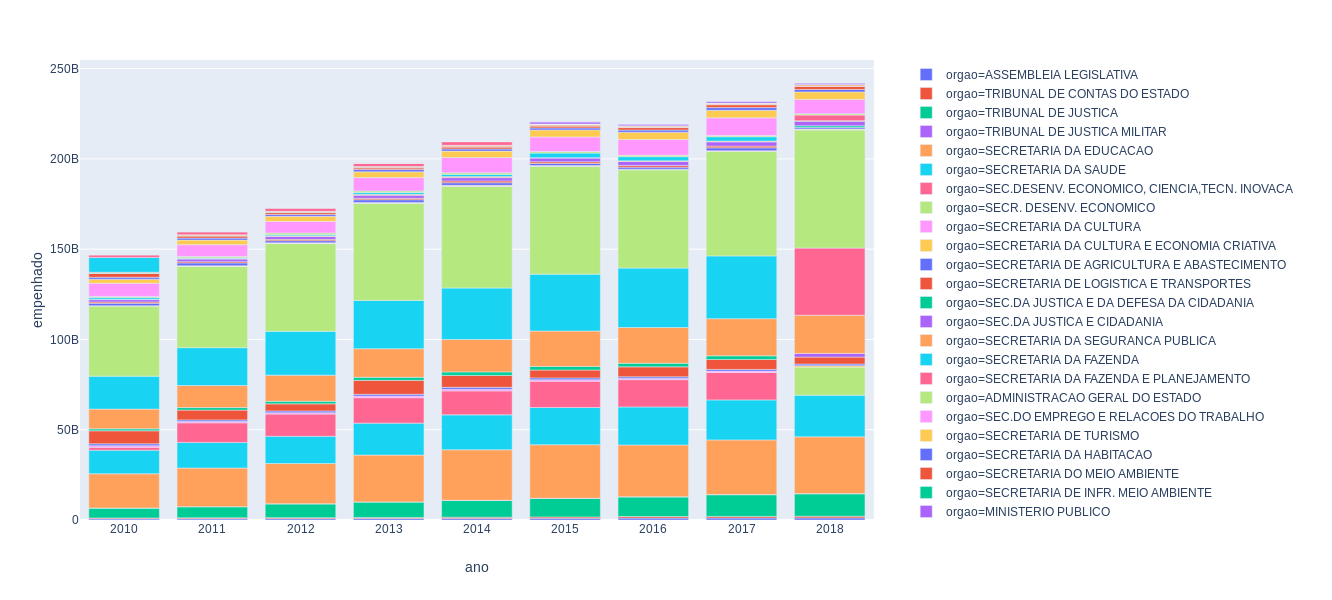

In [74]:
fig = px.bar(orgaos, x="ano", y=["empenhado"], color="orgao")
fig.show()

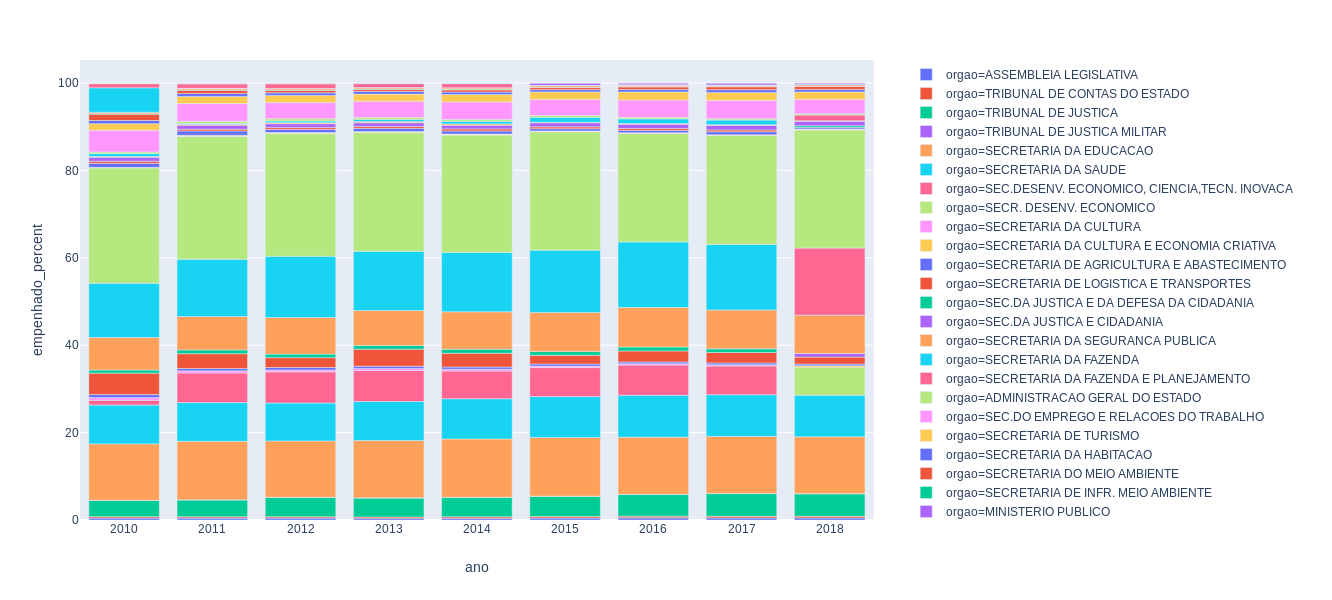

In [75]:
fig = px.bar(orgaos, x="ano", y="empenhado_percent", color="orgao")
fig.show()